# Homework 3

**Bootstrap and Testing**

1. Test the hypothesis that the survival rates for female passengers in Pclass 1 was no larger than in Pclass 2.
2. Create a boxplot `mpg ~ cylinders`. It does seem that the mpg for cars with 4 cylinders is quite different from those with 3 cylinders. What does a bootstrap test tell you about this hypothesis?
3. Can you think of more interesting hypotheses to test regarding the pregnancy data ?

In [1]:
%run ../ourFunctions.py

## Task 1
Test the hypothesis that the survival rates for female passengers in Pclass 1 was no larger than in Pclass 2.

In [2]:
#Titanic data:
import seaborn as sns
titanic = sns.load_dataset('titanic')

### EDA

In [3]:
# Survival rate per class and sex
surv_rate_group = titanic[['survived', 'pclass', 'sex']].groupby(["pclass", "sex"]).mean()

# Survival rate for female passengers in Pclass 1 and Pclass 2
surv_rate_pcf1 = surv_rate_group.xs(key="female",level=1).iloc[0,0]
surv_rate_pcf2 = surv_rate_group.xs(key="female",level=1).iloc[1,0]

print("Survival rate for female passengers in Pclass 1",round(surv_rate_pcf1,2))
print("Survival rate for female passengers in Pclass 2",round(surv_rate_pcf2,2))

Survival rate for female passengers in Pclass 1 0.97
Survival rate for female passengers in Pclass 2 0.92


In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

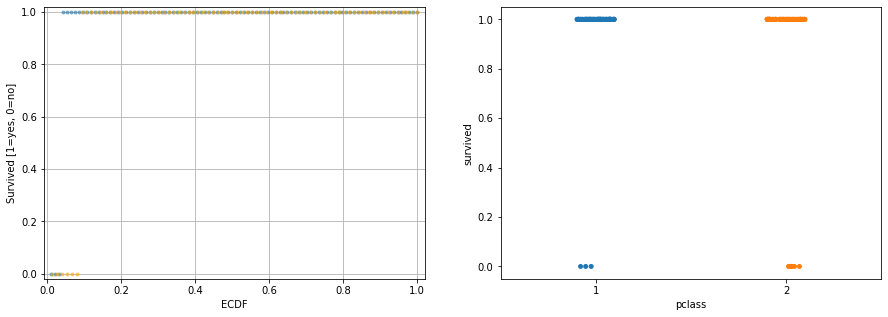

In [5]:
titanic_small = titanic[['survived', 'pclass', 'sex']]

# Filter df for female passengers in Pclass 1 and Pclass 2 
pcf1 =titanic_small[(titanic_small["sex"]=="female") & (titanic_small["pclass"]==1)]["survived"]
pcf2 =titanic_small[(titanic_small["sex"]=="female") & (titanic_small["pclass"]==2)]["survived"]

# Compute ECDF for female passengers in class 1 and 2 
x_1, y_1 = ecdf(pcf1)
x_2, y_2 = ecdf(pcf2)

#Create two subplots 
figure, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

#Plot 1:

# Plot all ECDFs on the same plot
ax1.plot(y_1, x_1, marker = '.', linestyle = 'none', alpha=0.5)
ax1.plot(y_2, x_2, marker = '.', linestyle = 'none', alpha=0.5, color="orange")

# Make nice margins
ax1.margins(0.02)
ax1.set_ylabel("Survived [1=yes, 0=no]")
ax1.set_xlabel("ECDF")

# Add grid
ax1.grid()

#--------------------------------------
#Plot 2:
female_both_classes = titanic_small[(titanic_small["sex"]=="female") & ((titanic_small["pclass"]==1) | (titanic_small["pclass"]==2))]
ax2 = sns.stripplot(x="pclass",y="survived", data=female_both_classes);


### Hypothesis testing through permutation sampling

1. Clearly state the null hypothesis: \
The survival rates for female passengers in Pclass 1 was not larger than in Pclass 2

2. Define your test statistic: \
Survival rate 
----
3. Generate many sets of simulated data assuming the null hypothesis is true (Permutation samples)

In [6]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

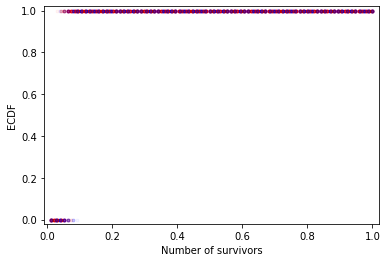

In [7]:
for i in range(0,50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(pcf1,pcf2)

    # Compute ECDFs
    yp_1, xp_1 = ecdf(perm_sample_1)
    yp_2, xp_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(xp_1, yp_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(xp_2, yp_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
y_1, x_1 = ecdf(pcf1)
y_2, x_2 = ecdf(pcf2)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', alpha=0.02)
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', alpha=0.02)

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Number of survivors')
_ = plt.ylabel('ECDF')
plt.show()

ECDFs from the permutation samples do overlap with the observed data, suggesting that the hypothesis is commensurate with the data.

---
4. Compute the test statistic for each simulated data set

In [8]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

In [9]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)

    return diff

In [10]:
# Compute difference of survival rate from df: empirical_diff_means
empirical_diff_means = diff_of_means(pcf1,pcf2)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(pcf1, pcf2, diff_of_means, size=10000)

5. Compute p-value: p

In [11]:
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)


p-value = 0.1463


**ANSWER:** 
The p-value tells us that there is about a 15,26% chance that we would get the difference of survival-rate observed in the experiment if survival rate for pclasses for female passengers were exactly the same. Since the p-value is above 0.05 the result is **not statistically significant**. We therefore reject the null hypothesis.

## Task 2
Create a boxplot `mpg ~ cylinders`. It does seem that the mpg for cars with 4 cylinders is quite different from those with 3 cylinders. What does a bootstrap test tell you about this hypothesis?

### Boxplot

3 cylinders: Mean: 20.55 Std: 2.221 no_samples: 4
4 cylinders: Mean: 29.284 Std: 5.656 no_samples: 199


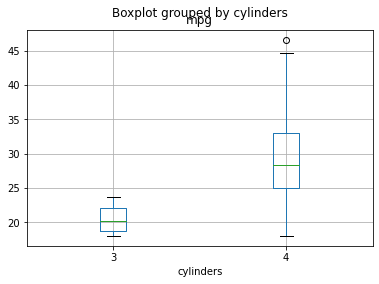

In [54]:
#Auto data:
cars = pd.read_csv('../data/Auto.csv')

#Filter df for cars with 3 or 4 cylinders
cars_cyl_34 = cars[(cars["cylinders"] == 3) | (cars["cylinders"] == 4)]

#Create boxplot
cars_cyl_34.boxplot("mpg", "cylinders");

#Print mean and std for both distributions:
mu_3_org = round(np.mean(cars[cars["cylinders"] == 3]["mpg"]),3)
mu_4_org = round(np.mean(cars[cars["cylinders"] == 4]["mpg"]),3)
std_3_org = round(np.std(cars[cars["cylinders"] == 3]["mpg"]),3)
std_4_org = round(np.std(cars[cars["cylinders"] == 4]["mpg"]),3)
no_samples_3 = cars[cars["cylinders"] == 3].shape[0]
no_samples_4 = cars[cars["cylinders"] == 4].shape[0]

print("3 cylinders: Mean:",mu_3_org, "Std:",std_3_org, "no_samples:", no_samples_3)
print("4 cylinders: Mean:",mu_4_org, "Std:",std_4_org, "no_samples:", no_samples_4)

### Bootstrap test

Null hypothesis: Cars with 3 and cars with 4 cylinders have the same mean mpg, but not necessarily the same distribution

In [74]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [75]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

In [81]:
#Create arrays of original distribution of mpg per cylinder
cars_cyl_3 = cars_cyl_34[(cars_cyl_34["cylinders"] == 3)]["mpg"]
cars_cyl_4 = cars_cyl_34[(cars_cyl_34["cylinders"] == 4)]["mpg"]

In [79]:
# Calculate mean of all cars with 3 and 4 cylinders:
mean_all = np.mean(cars_cyl_34["mpg"])

# Shift both arrays to have the same mean
cars3_shifted = cars_cyl_3 - np.mean(cars_cyl_3) + mean_all
cars4_shifted = cars_cyl_4 - np.mean(cars_cyl_4) + mean_all

In [88]:
# Compute 10,000 bootstrap replicates from shifted arrays
no_bs_samples = 10_000
cars_cyl_3_bs = draw_bs_reps(cars3_shifted, np.mean, no_bs_samples)
cars_cyl_4_bs = draw_bs_reps(cars4_shifted, np.mean, no_bs_samples)

# Get replicates of difference of means: bs_replicates
bs_replicates = cars_cyl_4_bs - cars_cyl_3_bs

# Compute and print p-value: p
p = np.sum(bs_replicates >= mean_all) / no_bs_samples
print('p-value =', p)

p-value = 0.0


The p-value tells us that there is a 0% chance that we would get the difference of means observed in the df if both car types were exactly the same. But the sample size of cars with 3 cylinders is really small. Therefore it could still be possible, that both car types have the same mean. 

### Alternative: Hypothesis tests based on a difference in means

The null hypothesis represents the case of no difference between the groups.
**Null hypothesis**: There is no difference in average mpg for cars with 3 and 4 cylinders (µn − µs = 0)
**Alternative hypothesis**: : There is some difference in average mpg for cars with 3 and 4 cylinders (µn − µs != 0).

In [65]:
#Compute diff of mean of original data: 
diff_mean_org = np.round(diff_of_means(cars_cyl_4, cars_cyl_3),3)
print("Diff_mean_original data:",diff_mean_org)

SE_org = np.sqrt((std_3_org**2/no_samples_3)+(std_4_org**2/no_samples_4))
print("SE of point estimation:", np.round(SE_org,3))

Diff_mean_original data: 8.734
SE of point estimation: 1.181


We check the two conditions necessary to apply the t distribution to the difference in sample means. :

1. In this df, the cars are independent of each other. But, the sample for cars with 3 cylinders is very small. The histogram of cyl 4 doen’t show any clear deviations from normality
2. The cars in each group are also independent of each other.

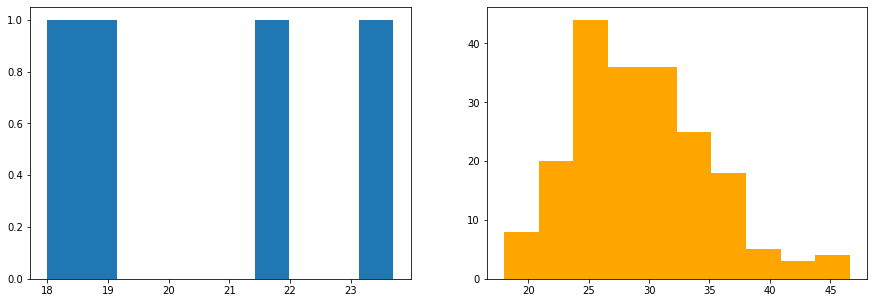

In [53]:
# Print both distributions
fig, (ax11, ax21) = plt.subplots(1,2, figsize=(15,5))
ax11.hist(cars_cyl_3);
ax21.hist(cars_cyl_4, color="orange");

In [66]:
T = (diff_mean_org - 0)/SE_org
print(np.round(T,3))

degree_freedom = no_samples_3-1
print(degree_freedom)

alpha = 0.05
print(alpha)

7.398
3
0.05


The T score falls even behind the last column in the df = 3 row of the t table, meaning the two-tailed p-value is lower than 0.01. This p-value is smaller than the significance value (alpha) 0.05, so we safely reject the null hypothesis. There is some difference in average mpg for cars with 3 and 4 cylinders

## Task 3
Can you think of more interesting hypotheses to test regarding the pregnancy data ?

In [ ]:
#pregnancy data:
#preg=pd.read_hdf('../data/pregNSFG.h5', 'df')
preg = pd.read_csv("../data/pregNSFG.csv.gz").drop(["Unnamed: 0"],axis=1)

#only look at live births
live = preg[preg.outcome == 1]
live.head()